In [383]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer

# graphics
from qiskit.visualization import plot_bloch_multivector
from IPython.display import clear_output, display

# mathematics
import numpy as np
from scipy.stats import unitary_group

# miscellaneous
import time

In [384]:
## CONSTANTS
NUMBER_OF_BITS = 1
NUMBER_OF_QUBITS = 2 # you will always have two qubits, you will only add more unitary gates to correct for error
MAX_REGISTERS = 5 # number of registers that ceases the simulation

In [385]:
## FUNCTIONS

# creates the entire dynamic circuit
def vmc_circuit(num_qubits, alpha, beta, unitary_matrix, register_number):
    vmc_circuit = QuantumCircuit(num_qubits, NUMBER_OF_BITS)
    
    # initialize states
    create_random_state(alpha, beta, unitary_matrix, register_number, vmc_circuit)
    create_plus(vmc_circuit)
    vmc_circuit.barrier()
    
    # add unitaries and CNOTs
    add_gates(vmc_circuit, unitary_matrix, register_number)

    # add measurement on |+> register
    # if result is |0>, then it is success
    # if result is |1>, thes it is failure and we have to correct the state
    vmc_circuit.measure(1, 0)

    return vmc_circuit


# adds needed number of unitaries and CNOTs
def add_gates(quantum_circuit, unitary_matrix, register_number):
    number_of_gates_applied_on_register = 2**(register_number - 1) # calculates number of unitaries in register register_number
    for unitary in range(0, number_of_gates_applied_on_register):
         # applying required number of unitaries on the correct register
         quantum_circuit.unitary(unitary_matrix, [1], label=r"$U_{\varphi}$")
    

# creates starting states |+> everywhere except for the first register
def create_plus(quantum_circuit):
    quantum_circuit.h(1)


# creates random qubit state
def create_random_state(alpha, beta, unitary_matrix, register_number, quantum_circuit):
    norm = np.sqrt(abs(alpha)**2 + abs(beta)**2) # normalization
    state = [alpha / norm, beta / norm]

    # add or initialize this state in circuit
    quantum_circuit.initialize(state, 0)

    # Calculate the Hermitian conjugate (complex conjugate transpose)
    unitary_conjugate = np.conj(unitary_matrix.T)
    
    # apply hermitian conjugate of unitary required number of times
    num_of_conjugated_unitaries_applied = 2**(register_number - 1) - 1
    for i in range(0, num_of_conjugated_unitaries_applied): # need to add error from previous measurements
        quantum_circuit.unitary(unitary_conjugate, [0], label=r"$U_{\varphi}^{\dagger}$")

In [386]:
## FUNCTIONS TO CREATE STATIC RESULTING CIRCUIT THAT WAS SUCCESSFUL IN THE END

# creates the entire static circuit
def vmc_circuit_static(register_number, alpha, beta, unitary_matrix):
    vmc_circuit = QuantumCircuit(register_number + 1, NUMBER_OF_BITS)
    
    # initialize states
    create_random_state_static(alpha, beta, vmc_circuit)
    create_plus_static(vmc_circuit)
    vmc_circuit.barrier()
    
    # add unitaries and CNOTs and measurements
    add_gates_static(vmc_circuit, unitary_matrix)

    return vmc_circuit


# adds unitaries, CNOTs and measurements
def add_gates_static(quantum_circuit, unitary_matrix):
    num_qubits = quantum_circuit.num_qubits
    if num_qubits < 2:
        return

    # unitaries
    number_of_gates_applied_on_register = 1 # you start with one gate applied and then double it for every new register
    quantum_circuit.unitary(unitary_matrix, [1], label=r"$U_{\varphi}$") # unitary on first register
    for register in range(2, num_qubits):
        number_of_gates_applied_on_register *= 2
        for unitary in range(0, number_of_gates_applied_on_register):
            # applying required number of unitaries on the correct register
            quantum_circuit.unitary(unitary_matrix, [register], label=r"$U_{\varphi}$")
    
    # CNOTs and measurements
    for qubit in range(1, num_qubits):
        quantum_circuit.cx(quantum_circuit.qubits[0], quantum_circuit.qubits[qubit])
        quantum_circuit.measure(quantum_circuit.qubits[qubit], 0)


def create_plus_static(quantum_circuit):
    num_qubits = quantum_circuit.num_qubits
    for qubit in range(1, num_qubits):
        quantum_circuit.h(quantum_circuit.qubits[qubit])


# creates random qubit state
def create_random_state_static(alpha, beta, quantum_circuit):
    norm = np.sqrt(abs(alpha)**2 + abs(beta)**2) # normalization
    state = [alpha / norm, beta / norm]
    
    # add or initialize this state in circuit
    quantum_circuit.initialize(state, 0)

In [387]:
# create probability amplitudes for initial state
alpha, beta = np.random.rand(2) + 1j * np.random.rand(2)

# create random unitary you want to apply on initial state |\psi>
unitary_matrix = unitary_group.rvs(2) # generates random 2x2 unitary

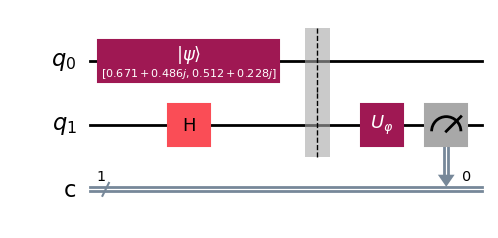

In [388]:
## CREATE INITIAL CIRCUIT

register_number = 1 # in the beginning you start with only one register (or the first one)
qc = vmc_circuit(NUMBER_OF_QUBITS, alpha, beta, unitary_matrix, register_number)

# with qc.while_loop((qc.clbits[0], 1)): # if the result is |1>, then the measurement was unsuccessful and you need to correct it
#     number_of_qubits += 1
#     qc = vmc_circuit(number_of_qubits, NUMBER_OF_BITS)
#     measured_qubit += 1
#     qc.measure(measured_qubit, 0)

# in the resulting circuit you should always have one more unitary applied on |+> than one hermitian conjugate on |\psi> 
qc.draw(output='mpl', fold=-1) 

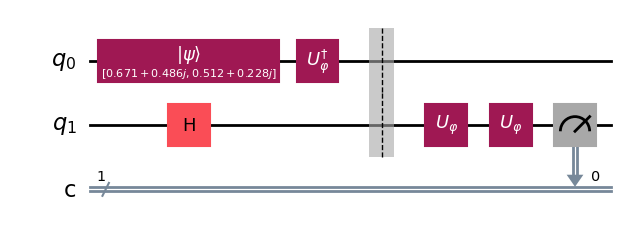

[{'1': 1}, {'0': 1}]


In [389]:
## SIMULATION
# with dynamic creation of circuits

register_number = 1
shots = 1 # you have only one measurement and based on its success you are either expanding circuit or not
list_of_results = []
qasm_simulator = Aer.get_backend("qasm_simulator")
while register_number <= MAX_REGISTERS:    
    transpiled_qc = transpile(qc, qasm_simulator)
    result = qasm_simulator.run(transpiled_qc, shots=shots).result()
    counts = result.get_counts()
    list_of_results.append(counts)

    # Clear the previous output and display the updated circuit
    clear_output(wait=True)
    display(qc.draw(output='mpl', fold=-1))  # Use Matplotlib for a nice circuit diagram
    # Pause for 1 second to simulate real-time update
    time.sleep(1)

    # if the result of measurement is |0>, we can end the loop, because U_{\varphi} is successfully applied on initial state \psi
    if "0" in counts:
        break
    
    # if you want to check the statevector
    # however the results will not be in agreement with qasm_simulator as those are two separate "experiments"
    # statevector_simulator = Aer.get_backend("statevector_simulator")
    # transpiled_qc = transpile(qc, statevector_simulator)
    # result = statevector_simulator.run(transpiled_qc, shots=shots).result()
    # statevector = result.get_statevector()
    # print(statevector)

    # create new circuit that simulates the unsuccessful result of previous measurement (i.e. |1>)
    register_number += 1
    qc = vmc_circuit(NUMBER_OF_QUBITS, alpha, beta, unitary_matrix, register_number)
    

# print list of results for you circuits
print(list_of_results)

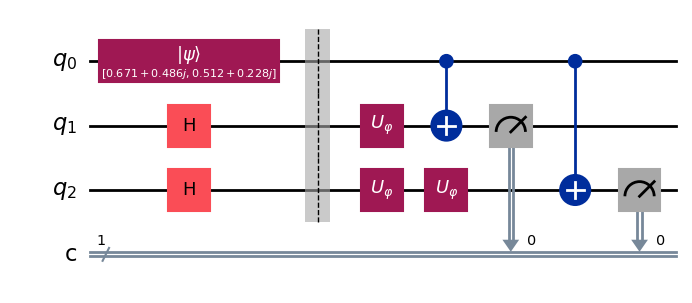

In [390]:
# draw the entire circuit in one piece
qc_resulting = vmc_circuit_static(register_number, alpha, beta, unitary_matrix)
qc_resulting.draw(output='mpl', fold=-1)